# SMS水面抜け

## 準備
高速化のために[numpy](https://numpy.org/doc/stable/reference/index.html#reference)と[pytorch](https://pytorch.org/docs/stable/index.html)を使います

In [ ]:
!pip install numpy torch tqdm sms-gap==0.1.0

次に、必要なpackageをimportします

In [ ]:
# cudaを使う場合は次の命令をuncommentしてください
#%set_env SMS_PYTORCH_DEVICE=cuda

In [1]:
import time # 実行時間を計るため
from tqdm.notebook import tqdm # progress bar
import numpy as np
import torch
from itertools import combinations as combin
import operator as op
import logging
from functools import reduce
from sms.gap import find_x, find_z, find_neigh, find_all, find_in_result, verify, frange, f32, binsearch
logger = logging.getLogger('SMS-gap')

def hook():
  from memorylib import Dolphin
  global d, dolphin
  d = dolphin = Dolphin()
  assert dolphin.find_dolphin(), 'Dolphin not found'
  assert dolphin.init_shared_memory(), 'MEM1 not found'
  assert dolphin.read_ram(0, 3).tobytes() == b'GMS', 'Current game is not Sunshine'

import struct
read_struct = lambda addr, fmt: struct.unpack(fmt, d.read_ram(addr-0x80000000, struct.calcsize(fmt)))
read_ptr = lambda addr: d.read_uint32(addr)

In [ ]:
# 後からdeviceを変更したい時は次のようにpackageをreloadする必要があります
## 使うdevice
#%set_env SMS_PYTORCH_DEVICE=cpu
#import importlib
#import sms.gap
#importlib.reload(sms.gap)
#from sms.gap import find_x, find_z, find_neigh, find_all, find_in_result, verify, frange, f32

## 境界を指定

### 方法1: 座標で指定

In [2]:
bd = (
  (-6000, -33900),
  ( 6200,  32700),
)

### 方法2: 二つの三角形の座標(hex形式)で指定
[Dolphin-memory-engine](https://github.com/aldelaro5/Dolphin-memory-engine)
を使う場合、次のように設定すれば水面の三角形の座標をhex形式で取得できます。

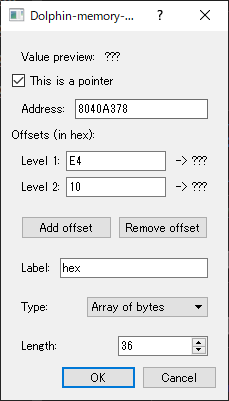

Level 2について、  
水面三角形を調べる場合は`E4`にし、  
普通の床三角形を調べる場合は`E0`にします。

In [3]:
# 三角形1のhex
raw1 = 'C5 BB 80 00 00 00 00 00 C7 04 6C 00 C5 BB 80 00 00 00 00 00 46 FF 78 00 45 C1 C0 00 00 00 00 00 46 FF 78 00'

In [4]:
# 三角形2のhex
raw2 = 'C5 BB 80 00 00 00 00 00 C7 04 6C 00 45 C1 C0 00 00 00 00 00 46 FF 78 00 45 C1 C0 00 00 00 00 00 C7 04 6C 00'

In [5]:
tri1, tri2 = (
  np.frombuffer(bytes.fromhex(raw), '>f').reshape(-1, 3)[:3, [0,2]]
  for raw in (raw1, raw2)
)
print('三角形1の座標:\n', tri1)
print('三角形2の座標:\n', tri2)

bds = reduce(op.__and__, (
  set(map(
    frozenset, combin(map(tuple, tri), 2)
  ))
  for tri in (tri1, tri2)
)) 
assert len(bds)>0, '入力した三角形に共通の頂点座標がない'
if len(bds)>1: logger.warning('入力した三角形に共通の頂点座標が2個以上存在する')
bd = tuple(next(iter(bds)))
print('\n境界:', bd)

三角形1の座標:
 [[ -6000. -33900.]
 [ -6000.  32700.]
 [  6200.  32700.]]
三角形2の座標:
 [[ -6000. -33900.]
 [  6200.  32700.]
 [  6200. -33900.]]

境界: ((-6000.0, -33900.0), (6200.0, 32700.0))


### 方法3: memorylibを用いてDolphinから直接に読み込む
サンシャインを起動して`hook()`を実行します

In [6]:
hook()

2932239377344 0x2aab71623c0


調べるのは水面ならば`offset`を`0xE4`に、普通の床ならば`0xE0`にします

In [7]:
offset = 0xE4

Dolphinで一つ目の水面/床三角形に移動し、次の命令を実行します

In [8]:
tri1 = np.array(read_struct(read_ptr(read_ptr(0x8040A378)+offset)+0x10, '>9f')).reshape(3, 3)[:, [0,2]]
tri1

array([[ -6000., -33900.],
       [ -6000.,  32700.],
       [  6200.,  32700.]])

次に、Dolphinで二つ目の水面/床三角形に移動し、次の命令を実行します

In [9]:
tri2 = np.array(read_struct(read_ptr(read_ptr(0x8040A378)+offset)+0x10, '>9f')).reshape(3, 3)[:, [0,2]]
tri2

array([[ -6000., -33900.],
       [  6200.,  32700.],
       [  6200., -33900.]])

In [10]:
bds = reduce(op.__and__, (
  set(map(
    frozenset, combin(map(tuple, tri), 2)
  ))
  for tri in (tri1, tri2)
)) 
assert len(bds)>0, '入力した三角形に共通の頂点座標がない'
if len(bds)>1: logger.warning('入力した三角形に共通の頂点座標が2個以上存在する')
bd = tuple(next(iter(bds)))
print('境界:', bd)

境界: ((-6000.0, -33900.0), (6200.0, 32700.0))


## 探索
注意：逆算の誤差によりFalse Positive/False Negativeが発生する可能性があります

### 近傍の探索

In [11]:
axis = 'x' # x軸に沿って探索する
xC = -1000 # 探索の中心(x座標)
R = 50 # 探索の半径
max_count = 1e8 # 最大1億件探索する

t0 = time.time()
xzz, valid = find_neigh(axis, xC, 50, bd, max_count)
print('実行時間: %.3f(秒)'%(time.time()-t0))

実行時間: 0.133(秒)


#### すり抜けできるx座標の個数

In [12]:
valid.sum()

tensor(652310)

#### xC=-1000を中心に最も近い10+10件を表示

In [13]:
idxC = binsearch(xzz[:, 0], xC)
idxVC = valid[:idxC].sum()
xzzV = xzz[valid]

header = ('x', 'z Min', 'z Max') if axis=='x' else ('z', 'x Min', 'x Max')
print(*header, sep='\t\t')
for r in xzzV[:idxVC][-10:].flip(0).cpu().numpy():
  print(*r, sep='\t')

print()
print(*header, sep='\t\t')
for r in xzzV[idxVC:][:10].cpu().numpy():
  print(*r, sep='\t')

x		z Min		z Max
-1000.0003	-6604.9204	-6604.92
-1000.00037	-6604.9204	-6604.92
-1000.0004	-6604.9204	-6604.92
-1000.0005	-6604.9204	-6604.92
-1000.00055	-6604.9204	-6604.92
-1000.0006	-6604.9204	-6604.92
-1000.0007	-6604.9204	-6604.92
-1000.0017	-6604.928	-6604.9277
-1000.0018	-6604.928	-6604.9277
-1000.00183	-6604.928	-6604.9277

x		z Min		z Max
-999.99927	-6604.9126	-6604.912
-999.9992	-6604.9126	-6604.912
-999.99915	-6604.9126	-6604.912
-999.9991	-6604.9126	-6604.912
-999.999	-6604.9126	-6604.912
-999.99896	-6604.9126	-6604.912
-999.9989	-6604.9126	-6604.912
-999.99884	-6604.9126	-6604.912
-999.9988	-6604.9126	-6604.912
-999.99774	-6604.905	-6604.9043


#### 結果をcsvファイルに保存

In [14]:
with open('gap.csv', 'w') as fw:
  print(*header, sep=',', file=fw)
  for p in xzzV.cpu().numpy():
    print(*p, sep=',', file=fw)

### 全探索
探索効率のために、探索の領域を二つに分けてそれぞれx軸とz軸に沿って探索することにします

In [15]:
t0 = time.time()

# 探索
xzz, zxx = find_all(bd)
# 結果
xzzValid = xzz[:,1] <= xzz[:,2]
zxxValid = zxx[:,1] <= zxx[:,2]
xzzV = xzz[xzzValid]
zxxV = zxx[zxxValid]

print('実行時間: %.3f(秒)'%(time.time()-t0))
print(f'すり抜け可能/探索したx座標の個数: {xzzV.shape[0]:,} / {xzz.shape[0]:,}')
print(f'すり抜け可能/探索したz座標の個数: {zxxV.shape[0]:,} / {zxx.shape[0]:,}')

実行時間: 14.402(秒)
すり抜け可能/探索したx座標の個数: 17,028,477 / 49,272,585
すり抜け可能/探索したz座標の個数: 8,641,209 / 49,622,817


例えば、コロロの水面の場合、x=197.4539\~6199.9985まではx軸に沿って探索し、それ以外(z=-33900\~-11320)はz軸に沿って探索します。

In [16]:
print('\t    x\t\tz Min\t    z Max')
print(xzzV)
print('\t    z\t\tx Min\t    x Max')
print(zxxV)

	    x		z Min	    z Max
tensor([[  197.4539,   -67.9980,   -67.9971],
        [  197.4539,   -67.9980,   -67.9971],
        [  197.4539,   -67.9980,   -67.9971],
        ...,
        [ 6199.9966, 32699.9805, 32699.9805],
        [ 6199.9971, 32699.9805, 32699.9824],
        [ 6199.9985, 32699.9902, 32699.9902]])
	    z		x Min	    x Max
tensor([[-3.3900e+04, -6.0000e+03, -6.0000e+03],
        [-3.3900e+04, -6.0000e+03, -6.0000e+03],
        [-3.3900e+04, -6.0000e+03, -6.0000e+03],
        ...,
        [-1.1320e+03,  2.5457e+00,  2.5461e+00],
        [-1.1320e+03,  2.5457e+00,  2.5461e+00],
        [-1.1320e+03,  2.5457e+00,  2.5461e+00]])


#### 結果を保存(ファイルサイズが大きいので注意！)

In [17]:
torch.save((xzzV, zxxV), 'result.pt')

In [18]:
!ls -lh result.pt
# コロロの水面抜け可能座標をファイルに保存すると294MBなります

-rw-r--r-- 1 sup39 None 294M Jun 17 16:28 result.pt


#### 結果をcsvファイルに保存
ファイルが非常に大きくなるのでおすすめしません！

例えばコロロの水面の場合、合計約750MBになりました。
ファイルサイズが大きすぎてExcelなどでは開けない可能性が高いので、
保存するとしたら`torch.save()`を使うことをおすすめします。

In [ ]:
for sfx, rsfx, a in zip('xz', 'zx', (xzzV, zxxV)):
  with open(f'result-{sfx}.csv', 'w') as fw:
    print(sfx, rsfx+' Min', rsfx+' Max', sep=',', file=fw)
    for p in tqdm(a.cpu().numpy()):
      print(*p, sep=',', file=fw)

#### 全探索の結果で調べる

In [19]:
# 保存した結果を読み込む
xzzV, zxxV = torch.load('result.pt')

##### 特定のx座標

In [20]:
find_in_result('x', f32(-1000.00037), xzzV, zxxV)
# x, z Min, z Max

tensor([[-1000.0004, -6604.9204, -6604.9199]])

##### 特定のz座標

In [21]:
find_in_result('z', -6604.9204, xzzV, zxxV)
# z, x Min, x Max

tensor([[-6604.9204, -1000.0007, -1000.0003]])

In [22]:
# 何も返さなかったら該当なし
find_in_result('z', -6604, xzzV, zxxV)

tensor([], size=(0, 3))

##### 近傍での探索

In [23]:
find_in_result('x', frange(950, 1050), xzzV, zxxV)

tensor([[ 950.0003, 4040.1663, 4040.1667],
        [ 950.0004, 4040.1663, 4040.1667],
        [ 950.0004, 4040.1663, 4040.1667],
        ...,
        [1049.9994, 4586.0605, 4586.0610],
        [1049.9995, 4586.0605, 4586.0610],
        [1049.9996, 4586.0605, 4586.0610]])

In [24]:
r = find_in_result('z', frange(950, 1050), xzzV, zxxV)
r

tensor([[ 950.0059,  383.9348,  383.9353],
        [ 950.0059,  383.9348,  383.9353],
        [ 950.0060,  383.9348,  383.9353],
        ...,
        [1049.9987,  402.2517,  402.2522],
        [1049.9988,  402.2517,  402.2522],
        [1049.9989,  402.2517,  402.2522]])

##### 結果をcsv形式でexport

In [25]:
axis = 'z'

header = ('x', 'z Min', 'z Max') if axis=='x' else ('z', 'x Min', 'x Max')
with open('gap.csv', 'w') as fw:
  print(*header, sep=',', file=fw)
  for p in r.cpu().numpy():
    print(*p, sep=',', file=fw)

## LICENSE